# Import Python Libraries

In [1]:
# import needed libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
#import skimage.morphology as morp
#from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix


import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
import matplotlib.image as mpimg


import math #test on server

In [2]:
from utility import *

# Load Data Set

In [17]:
#load data in form of np array
data_b = np.load('images_benign.npy')
print("# benign:", data_b.shape)

data_m = np.load('images_mali.npy')
print("# malignant:", data_m.shape) 

dim = int(math.sqrt(data_b.shape[1] / 3 )) # dimension of the image
print("dimension of images:", dim)

# benign: (8061, 7500)
# malignant: (1954, 7500)
dimension of images: 50


In [18]:
#vertically stack files
data = np.vstack((data_b,data_m))
print("original data shape:", data.shape)

# create labelset (benign = 0, malignant = 1)
label_b = np.zeros((data_b.shape[0],1),dtype=np.uint8)# an array of all zeros
label_m = np.ones((data_m.shape[0],1),dtype=np.uint8) # an array of all ones
y_train = np.vstack((label_b,label_m)) # training label

original data shape: (10015, 7500)


## train test separation

In [19]:
data_train, label_train, data_valid, label_valid, data_test, label_test = train_test_shuffled_separation(data, y_train)

shuffled data shape: (10015, 7500) shuffled label shape: (10015,)
# train: 7211
# valid: 801
# test: 2003
# total: 10015


## reshape image arrays to N x size x size x 3

In [20]:
data_train = data_train.reshape((data_train.shape[0], dim, dim, 3))
data_valid = data_valid.reshape((data_valid.shape[0], dim, dim, 3))
data_test = data_test.reshape((data_test.shape[0], dim, dim, 3))

## normalize image arrays to 0 - 1 

In [21]:
data_train = normalize_data(data_train)
data_valid = normalize_data(data_valid)
data_test = normalize_data(data_test)

# Display images from dataset

In [22]:
# function to display the images
def list_images(data, label, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(data))
        
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(data[indx].shape) == 2 else cmap
        plt.imshow(data[indx], cmap = cmap)
        
        #plt.xlabel(signs[dataset_y[indx]])
        #plt.ylabel(ylabel)
        
        plt.xticks([])
        plt.yticks([])
    #plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

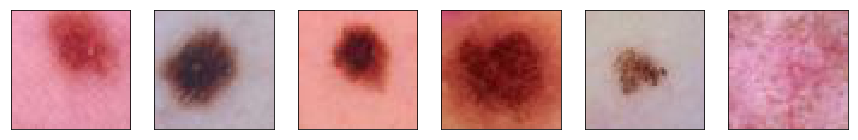

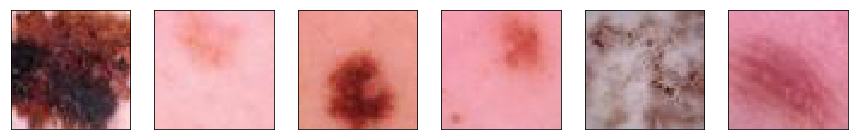

In [31]:
# plot the sample images
list_images(data_train, label_train)
list_images(data_test, label_test)

# Data Preprocessing

In [ ]:
# shuffle the order of the training images to randomize
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
# convert images to gray scale
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [ ]:
# sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

In [ ]:
# equalize the grayscale images
def local_equalize(image):
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

In [ ]:
# Sample images after equalization
equalized_images = list(map(local_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

In [ ]:
# normalize the images on a 0 - 1 scale
def image_normalize(image):
    image = np.divide(image, 255)
    return image

In [ ]:
# sample images after normalizing
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [ ]:
# preprocess the inputs
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

# LaNet Convultional Neural Net 

In [ ]:
# LaNet Convolutional Neural Network Class
class LaNet:  
    
    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # hyperparameters
        self.mu = mu
        self.sigma = sigma

        # layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = 1
        self.conv1_output = 6
        # weight and bias
        self.conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # apply Convolution
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias
        
        # activation:
        self.conv1 = tf.nn.relu(self.conv1)
        
        # pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # weight and bias
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # apply Convolution
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
        
        # activation:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = flatten(self.conv2)
        
        # layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
        
        # activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # aaving all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

# VGG Convolutional Class for 50x50

In [ ]:
# VGG Convolutional Neural Network Class for 50x50x3 image
class VGGnet:  

    def __init__(self, n_out=2, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 50x50x3. Output = 50x50x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 50x50x32. Output = 50x50x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 50x50x32. Output = 25x25x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)
        
        # Layer 4 (Convolutional): Input = 25x25x32. Output = 25x25x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 25x25x64. Output = 25x25x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 4 * initial_num_out), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(4 * initial_num_out))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 4 * initial_num_out), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(4 * initial_num_out))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples


# Train the Model

In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

In [ ]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [ ]:
# validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

In [ ]:
# initialize the number of epochs and batch size
EPOCHS = 30
BATCH_SIZE = 64

In [ ]:
# train using LeNet CNN
LeNet_Model = LaNet(n_out = n_classes)
model_name = "LeNet"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training ...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})
            
        validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))

In [ ]:
# train using VGG CNN
VGGNet_Model = VGGnet(n_out = 2)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))

# Testing

In [ ]:
# pre-process the test set of images
X_test_preprocessed = preprocess(X_test)

In [ ]:
# test accuracy
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum((y_test == y_pred)/len(y_test))
    print("Test Accuracy = {:.1f}".format(test_accuracy*10000))

In this project we trained a neural network to recognize German road signs. For this we began by doing image recognition research. A similar problem to this is the Cifar10 problem where there is a large dataset in Keras with 10 categories of images and the net can identify the images to a category such as airplane, car, cat, dog, etc. In our case, our categories are different road signs. We did things differently. Instead of using Keras, we went with a TensorFlow approach. We found the data online and it was already converted to a binary format making it easier to load than a folder of images. Our data set has 34799 training images, 12630 testing images, and 4410 validating images. In the data, there are 43 types of signs, so 43 classes. Additionally, all of the images are 32 by 32 pixels with RGB color.

For our process, we began by loading the images into train, validate, and test sets. We then sorted them further by putting them in x and y sets. In our case, the x is the image and y is the class the image belongs to. Just to make sure we loaded the data correctly, we printed the number of images in the categories and also displayed 6 random images in the train, validate, and test sets to get an idea of what the images look like.
 
The next step was preprocessing our data. To do so, we began by shuffling the order of the images to randomize things and make our model more accurate. Then we converted the images to grayscale images and displayed a few to make sure the process was done correctly. This is a technique done to spread out the intensity values of the image. Then we normalized the images to change the pixel intensity range. 

The next part was to create the actual neural networks. For this, we used 2 Convolutional Neural Networks. First, we used LeNet-5 which is normally used for handwriting recognition. The second is VGGNet which is another convolutional neural network used for large scale image recognition. We got both of these online (see help received).

The final steps were training and testing. For training we used 30 epochs for each of the convolutional neural networks. After training both they both had accuracy in the high 90%. In order to test, we used the test image data set. When testing we reached an accuracy of __%. As seen by our results, the model is able to detect the German road signs accurately. 

Through this project, we learned a lot about Tensor Flow. This was also probably the most difficult part. Due to using Keras more in class, this was a challenge we had to overcome. After doing so, we were very pleased with the results and seemed to learn a lot about image recognition with tensorflow. This is very interesting to us due to the possibilities of use of this technology. It opened our eyes to the possibility of using image recognition for things like robot navigation, face recognition software, and handwriting recognition. 
